### Bibliotecas
 Primeiramente baixaremos a bibliotecas necessárias para criação do modelo e visualização dos resultados
 

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


Localizamos o conjunto de dados dentro de um diretório com o código abaixo

In [2]:
folder_path = r'C:\Users\Gefferson\Documents\Vision\Vision\Scenario9\scenario9_dev'
try: 
    csv_file = [f for f in os.listdir(folder_path) if f.endswith('.csv')][0]
    csv_path = os.path.join(folder_path, csv_file)
except:
    raise Exception(f'No csv file inside {folder_path}.')
print(csv_path)

C:\Users\Gefferson\Documents\Vision\Vision\Scenario9\scenario9_dev\scenario9.csv


### Conjunto de Dados
A partir do diretório e o caminho para o arquivo com o conjunto de dados iremos realizar o carregamento dos dados

In [11]:
dataframe = pd.read_csv(csv_path, usecols=['unit1_rgb', 'unit1_beam_index'])
print(dataframe.head())

                                         unit1_rgb  unit1_beam_index
0  ./unit1/camera_data/image_BS2_2680_16_45_05.jpg                 2
1  ./unit1/camera_data/image_BS2_2681_16_45_05.jpg                 2
2  ./unit1/camera_data/image_BS2_2682_16_45_06.jpg                 2
3  ./unit1/camera_data/image_BS2_2683_16_45_06.jpg                 2
4  ./unit1/camera_data/image_BS2_2684_16_45_06.jpg                 3


Podemos ver que temos diferentes valores de classes, num total de 64 classes.

In [12]:
dataframe['unit1_beam_index'].unique()

array([ 2,  3,  6,  9, 10, 11, 13, 17, 20, 22, 23, 26, 29, 33, 34, 37, 39,
       42, 44, 45, 47, 48, 49, 51, 54, 55, 58, 59, 60, 61, 62,  4,  8, 14,
       19, 21, 28, 31, 40, 43, 57,  7, 36, 41, 53, 30, 63, 18, 27, 38, 46,
       52, 15, 16, 32,  5, 25, 12, 56, 24, 50, 35], dtype=int64)

No entanto iremos reduzir o número de classes para 32, onde classes a cada 2 feixes próximos serão considerados como um único feixe. 
Devido aos feixes estarem muito próximos entre sí essa redução no número de classes não afetará o desempenho da transmissão. 

In [13]:
old = list(np.linspace(1,63,32))
new= list(np.linspace(2,64,32))
dataframe['unit1_beam_index'] =  dataframe['unit1_beam_index'].replace(old, new)
dataframe['unit1_beam_index'].unique()


array([ 2,  4,  6, 10, 12, 14, 18, 20, 22, 24, 26, 30, 34, 38, 40, 42, 44,
       46, 48, 50, 52, 54, 56, 58, 60, 62,  8, 28, 32, 36, 64, 16],
      dtype=int64)

In [15]:
dataframe['unit1_beam_index'] = dataframe['unit1_beam_index'].astype(str)
print(dataframe.dtypes)

unit1_rgb           object
unit1_beam_index    object
dtype: object


Abaixo podemos verificar exemplos das imagens que estamos utilizando no conjunto de dados:

C:\Users\Gefferson\AppData\Local\Temp\ipykernel_5252\2931442729.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 5964 + 1) instead
  selected_samples = np.random.random_integers(0, dataframe.shape[0], size=[4])


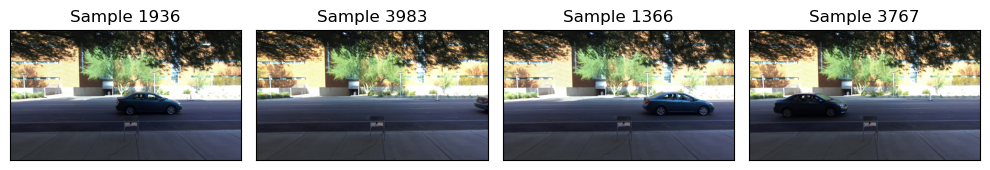

In [17]:


selected_samples = np.random.random_integers(0, dataframe.shape[0], size=[4])
img_rel_path = dataframe['unit1_rgb'].values
fig, axes = plt.subplots(figsize=(10,4), ncols=len(selected_samples), 
                         tight_layout = True)
for i, sample_idx in enumerate(selected_samples):
    img_abs_path = os.path.join(folder_path, img_rel_path[sample_idx])
    img = plt.imread(img_abs_path)
    axes[i].imshow(img)
    axes[i].set_title(f'Sample {sample_idx}')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

### Separando o conjunto de dados
Abaixo é realizado uma separação entre 75% de dados para treinamento e 25% para teste. 

In [18]:
train, test = train_test_split(dataframe, test_size=0.25)
print(f'Train data set shape {train.shape}')
print(f'Test data set shape {test.shape}')

batch_size = 40

Train data set shape (4473, 2)
Test data set shape (1491, 2)


Utilizamos o ImageDataGenerator para realizar o preprocessamento das imagens dos conjuntos de dados. 
Só realizamos um rescale para deixamos e separaados o conjunto de dados de treinamento em 80% para treinamento em si e 20% para validação durante treinamento. 

In [19]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [20]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=folder_path,
    x_col="unit1_rgb",
    y_col='unit1_beam_index',
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
)


Found 3579 validated image filenames belonging to 32 classes.


In [21]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=folder_path,
    x_col="unit1_rgb",
    y_col='unit1_beam_index',
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

Found 894 validated image filenames belonging to 32 classes.


In [22]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=folder_path,
    x_col="unit1_rgb",
    y_col='unit1_beam_index',
    target_size=(200, 200),
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    
)

Found 1491 validated image filenames belonging to 32 classes.


### Criação do Modelo
Criamos o modelo utilizando um modelo ResNet50 pré-treinado com a ImageNet e modificando a saída para que conseguissemos classificar as 32 classes de feixes

In [23]:
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(200, 200 , 3),
    pooling='avg',
    classes=32,
    weights='imagenet'
)


resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(32, activation='sigmoid'))

In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
Total params: 24776352 (94.51 MB)
Trainable params: 24723232 (94.31 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-4)
resnet_model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=['accuracy'])

### Treinamento do modelo
Realizamos o treinamento do modelo com 15 epocas e utilizando um Learning Rate de 1E-4. 

In [26]:
resnet_model.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=15)

Epoch 1/15
89/89 [==============================] - 534s 6s/step - loss: 1.2963 - accuracy: 0.5858 - val_loss: 4.2798 - val_accuracy: 0.1057
Epoch 2/15
89/89 [==============================] - 483s 5s/step - loss: 0.8072 - accuracy: 0.6921 - val_loss: 8.2817 - val_accuracy: 0.0273
Epoch 3/15
89/89 [==============================] - 523s 6s/step - loss: 0.7380 - accuracy: 0.7143 - val_loss: 11.6776 - val_accuracy: 0.0193
Epoch 4/15
89/89 [==============================] - 567s 6s/step - loss: 0.6266 - accuracy: 0.7545 - val_loss: 11.4242 - val_accuracy: 0.0250
Epoch 5/15
89/89 [==============================] - 565s 6s/step - loss: 0.5363 - accuracy: 0.7872 - val_loss: 14.4108 - val_accuracy: 0.0205
Epoch 6/15
89/89 [==============================] - 685s 8s/step - loss: 0.4502 - accuracy: 0.8194 - val_loss: 9.3283 - val_accuracy: 0.0352
Epoch 7/15
89/89 [==============================] - 643s 7s/step - loss: 0.3221 - accuracy: 0.8782 - val_loss: 6.2900 - val_accuracy: 0.0375
Epoch 8/15

### Teste do Modelo
A partir do dados de testes obtivemos uma acurácia de 65% para Top 1

In [27]:
score = resnet_model.evaluate(test_generator)

1491/1491 [==============================] - 79s 53ms/step - loss: 1.8108 - accuracy: 0.6506


In [29]:
#Save Model
#resnet_model.save('Scenario9model.keras')

In [30]:
#Load Saved Model
#resnet_model = keras.models.load_model("Scenario9model.keras")

Criando um vetor de classes preditdas a partir da saida do modelo

In [137]:
y_pred = resnet_model.predict(test_generator)
labels_pred = np.argmax(y_pred, axis=-1)
labels_pred

1491/1491 [==============================] - 88s 58ms/step


array([15,  5, 11, ..., 16, 17,  4], dtype=int64)

Vetor de classes corretas a partir dos dados utilizados para teste

In [54]:
labels_test = test_generator.classes
labels_test 

[17,
 3,
 12,
 21,
 12,
 9,
 19,
 4,
 15,
 31,
 3,
 2,
 4,
 28,
 9,
 31,
 28,
 26,
 31,
 17,
 8,
 26,
 9,
 0,
 31,
 22,
 29,
 1,
 29,
 9,
 7,
 18,
 28,
 8,
 5,
 22,
 0,
 29,
 11,
 29,
 22,
 23,
 20,
 5,
 21,
 13,
 3,
 29,
 5,
 31,
 5,
 5,
 29,
 9,
 5,
 16,
 9,
 5,
 6,
 28,
 25,
 27,
 6,
 19,
 7,
 29,
 7,
 7,
 18,
 11,
 23,
 29,
 5,
 5,
 21,
 16,
 29,
 16,
 22,
 28,
 23,
 16,
 1,
 29,
 26,
 29,
 1,
 28,
 21,
 7,
 23,
 29,
 18,
 21,
 29,
 28,
 12,
 17,
 4,
 23,
 29,
 13,
 2,
 9,
 27,
 15,
 6,
 16,
 13,
 19,
 22,
 28,
 5,
 22,
 28,
 18,
 19,
 0,
 20,
 28,
 13,
 1,
 28,
 28,
 29,
 23,
 9,
 21,
 1,
 29,
 3,
 4,
 22,
 22,
 2,
 19,
 29,
 6,
 23,
 16,
 25,
 28,
 24,
 25,
 25,
 4,
 23,
 12,
 16,
 7,
 2,
 29,
 16,
 29,
 13,
 16,
 30,
 17,
 25,
 19,
 16,
 10,
 21,
 21,
 7,
 25,
 18,
 17,
 18,
 25,
 20,
 18,
 10,
 4,
 22,
 10,
 2,
 19,
 20,
 8,
 25,
 29,
 29,
 18,
 19,
 20,
 5,
 1,
 30,
 12,
 16,
 28,
 10,
 5,
 24,
 25,
 26,
 13,
 4,
 24,
 27,
 2,
 29,
 7,
 28,
 16,
 16,
 1,
 25,
 27,
 5,
 5,
 29,

### Plot da acurária

In [111]:
accuracy = [0.5858, 0.6921 , 0.7143, 0.7545, 0.7872, 0.8194,  0.8782, 0.9011, 0.9418, 0.9483, 0.9619, 0.9647, 0.9700, 0.9740]
val_accuracy = [0.1057, 0.0273, 0.0193, 0.0250, 0.0205, 0.0352, 0.0375, 0.0227, 0.1159, 0.4648, 0.8205, 0.8648, 0.9602, 0.9614]

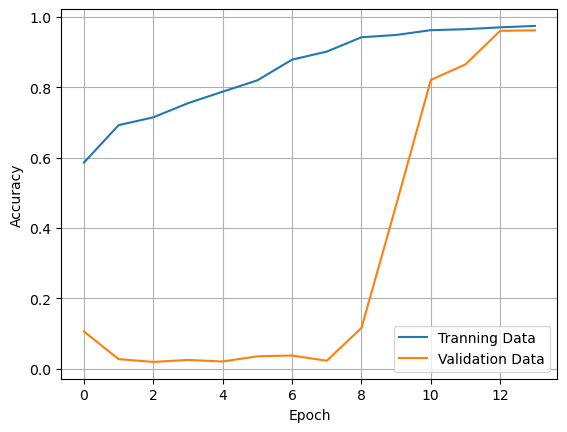

In [165]:
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Tranning Data', 'Validation Data'], loc='lower right')
plt.show()

### Verificando resultados para TOP 1, TOP 2 e TOP3

Abaixo criamos mais 2 vetores com as classes com valores dos 2 e dos 3 feixes que o modelo dá uma maior probabilidade de ser o feixe correto:

In [138]:
labels_pred_top2 = np.argsort(y_pred)[:][:,-2::]
labels_pred_top3 = np.argsort(y_pred)[:][:,-3::]

Top 1 foi obtido uma acurácia de 65,1%

In [161]:
sum(labels_test == labels_pred)/test.shape[0]

0.6505700871898055

Top 1 foi obtido uma acurácia de 89,9%

In [159]:
(sum(labels_pred_top2[:,0] == labels_test) + sum(labels_pred_top2[:,1] == labels_test))/test.shape[0]

0.8987256874580818

Top 1 foi obtido uma acurácia de 96,0%%

In [160]:
(sum(labels_pred_top3[:,0] == labels_test) + sum(labels_pred_top3[:,1] == labels_test) + sum(labels_pred_top3[:,2] == labels_test))/test.shape[0]

0.959758551307847